### Simulation based on  : 
* Prediction block RNN trained in [RNN_Train_StLaurentDeJourdes](RNN_Train_StLaurentDeJourdes.ipynb) 
    * To predict $X(k)$ and $Y(k)$  as respectively  $\tilde{X(k)}$ an  $\tilde{Y(k)}$ (Predictions on testing set are done in [RNN_Sim_StLaurentDeJourdes](RNN_Sim_StLaurentDeJourdes.ipynb))


Maximum voltage rise $vm_{pu}^{max} = 1.0250 $

---

#### Import Modules 


In [1]:
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
import ipyparallel as ipp
from tqdm import tqdm # Profiling 
import pickle, sys, importlib,  time
import os
from pickle import load
import joblib

In [9]:
# import psutil
function_folder = '../Modules/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
import oriClass as oriCs
from oriVariables import (simResult_folder,
                          Δt, 
                          ctrld_HvProd_name,
                          h_start_end, 
                          defAuth_hvBus_vRiseMax, 
                          defAuth_hvBus_vRiseMin, 
                          modules_folder, 
                          trainSet_end_M1, 
                          testSet_end_M1, 
                          lowerNet_file_loc, 
                          upperNet_file_loc,
                          default_hv_voltage,
                          pd_Δt, 
                          cleanedData_name) 
import checker

#### Import Networks


In [11]:
lowerNet=pp.from_pickle(lowerNet_file_loc)
upperNet=pp.from_pickle(upperNet_file_loc)

# Init an object of the class InitNetworks
networks = oriCs.InitNetworks(upperNet, lowerNet)

#### Import data Cleaned file for testing set

In [12]:
df_data = joblib.load(simResult_folder+cleanedData_name)

# Check whether the input dataframe columns are in the expected order
checker.check_networkDataDf_columnsOrder(df_data)

hvProd_names = list(df_data.columns[2:]) # Extract names of all HV prod in the Lower net

# Extract names of non controlled HV prods
nonCtrld_HvProd_name = set(hvProd_names).difference(set([ctrld_HvProd_name]))

per_index = df_data.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object)
                .between_time(*h_start_end) 
               ).index.to_period(pd_Δt)

# Extract the number of periods considered in a day
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])

# # Extract only the relavant testing set since the training set covers the first part of the data
df_final = df_data[(df_data.index>=trainSet_end_M1) & (df_data.index<=testSet_end_M1)]
per_index = df_final.index
per_index2 = ( pd.Series(index=per_index.to_timestamp(), dtype=object)
              .between_time(*h_start_end) 
             ).index.to_period(pd_Δt)

#### Load predicted data file

In [13]:
rnnPred_df = joblib.load(f'{simResult_folder}RNN_pred.pkl')

#### Operation on network parameters

In [14]:
# Defined Voltage rise threshold
vm_mu_max, vm_mu_min = defAuth_hvBus_vRiseMax, defAuth_hvBus_vRiseMin  

# Inititialize the controllable hv prod in the network
networks.init_controlled_hvProd(ctrld_HvProd_name)

# Extract the HV bus from the list of activated bus 
lowerNet_hv_activated_bus = networks.get_lowerNet_hvActivatedBuses(lowerNet
                                                                   .bus
                                                                   .query('vn_kv==@default_hv_voltage').index)
# Add maximum voltage constraints on the Hv Buses in the network 
networks.lowerNet_set_vrise_threshold(lowerNet_hv_activated_bus, vm_mu_min, vm_mu_max)

### Controllable Generators costs

In [15]:
# get the index of the controlled HV prod in SGEN table
ctrld_hvProd_index = lowerNet.sgen.query('name==@ctrld_HvProd_name').index

# Add negative cost to usability of sgen P0100 so its usage can be maximised while respecting the constraints on the network
pp.create_poly_cost(lowerNet, ctrld_hvProd_index,'sgen', cp1_eur_per_mw=-1)

lowerNet.poly_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,23,sgen,0.0,-1.0,0.0,0.0,0.0,0.0


#### Start Parallel engines

In [16]:
n_engines = os.cpu_count()-1         # Total number of engines
parEngines = oriCs.CreateParEngines(n_engines)

Starting 7 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/7 [00:00<?, ?engine/s]

## OPF  RNN

#### Redefine Data to use in local space of Parallel engines

In [39]:
# Parameters for the persistence model
opf_status = 'Both' 
pred_model = None

parameters_dict = dict({'lowerNet':lowerNet, 
                        'lowerNet_hv_activated_bus':lowerNet_hv_activated_bus, 
                        'sum_max_main_network':networks.get_upperNet_sum_max_lvProdLoad(), 
                        'vm_mu_max':vm_mu_max, 
                        'pred_model': pred_model
                       })


##### Create a function to rename Columns in the  RNN prediction dataframe 


    Ex: from => ['P0013_RNN', 'Prod_BT_RNN', 'P0100_RNN'] 
          to => [  'P0013',     'Prod_BT',     'P0100'  ]

In [33]:
rename_cols = lambda name_list : [name.split('_R')[0] for name in name_list]

##### Rename prediction Dataframe

In [34]:
rnnPred_df.columns = rename_cols(rnnPred_df)

##### Initialize variables for parallel engines


In [37]:
dict_df_sgenLoad = oriFc.createDict_prodHtBt_Load(rnnPred_df,
                                                  networks )

#### Send data into local space of each engine

In [40]:
df_prodHT_index = dict_df_sgenLoad['df_prodHT'].index # Extract index of periods the parallel 
                                                      # engines must work with.
        
# Send all the created variables into local spaces of each engine.
parEngines.sendVar_to_localSpace(df_prodHT_index, 
                                 opf_status, 
                                 dict_df_sgenLoad, 
                                 parameters_dict, 
                                 clean=True )

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing sys on engine(s)
importing oriFunctions on engine(s)


#### Run Optimal /power flow  in each local engine
**<span style='color:red'> -----------------  BLOC  PF/OPF -------------------  </span>**

In [41]:
%%px 
resulting_opf = [oriFunctions.run_powerflow_at(lowerNet, 
                                               cur_period,
                                               lowerNet_hv_activated_bus,
                                               sum_max_main_network, 
                                               dict_df_sgenLoad,
                                               vm_mu_max, 
                                               opf_status, 
                                               pred_model) 
                 for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

 <span style='color:red'> **-------------------------------------------------------**  </span>

#### Extract results

In [43]:
# Gather the result of each engine in a single list
results = parEngines.gather_results('resulting_opf')
time.sleep(1)

# Extract results
extracted_results = oriFc.extractParRes_asDf(results, df_prodHT)

### Reality check

**<span style='color:red'> -------------------  BLOC PROD  ---------------------</span>**

In [45]:
oriFc.block_prod(extracted_results, 
                 df_final[[ctrld_HvProd_name]] )

 <span style='color:red'> **-------------------------------------------------------**  </span>

#### Update Values for the dict to use for power flow


In [47]:
# Get the non controllable HV prod names
non_ctrld_HvProd_names_list = oriFc.get_nonCtrld_HvProd_names(df_final.columns[2:],
                                                              ctrld_HvProd_name ) 

# Update Values of the dataframe to use for final power flow bloc with Interest variables 
# (Real load, real Prod of LV Prod, and Non-COntroled HV Prod, Injected power of Ctrl Prod
df_final2 =pd.concat([df_final.loc[per_index2].iloc[:,[0,1]],
                      df_final.loc[per_index2, non_ctrld_HvProd_names_list],
                      extracted_results.loc[per_index2, [ctrld_HvProd_name]],
                     ], axis='columns')

# Check df_final2 columns order
checker.check_networkDataDf_columnsOrder(df_final2)    

# Creat dict to send to par Engines based
dict_df_sgenLoad = oriFc.createDict_prodHtBt_Load(df_final2,
                                                  networks )

opf_status = False 
df_prodHT_index = dict_df_sgenLoad['df_prodHT'].index # Extract  index of periods.

#### Send data into local space of each engine

In [48]:
parEngines.sendVar_to_localSpace(df_prodHT_index, 
                                 opf_status, 
                                 dict_df_sgenLoad, 
                                 parameters_dict, 
                                 clean=False )

#### Run power flow in each local engine
**<span style='color:red'> ------------------------ BLOC  PF  -----------------------  </span>**

In [49]:
%%px 
resulting = [oriFunctions.run_powerflow_at(lowerNet, 
                                           cur_period, 
                                           lowerNet_hv_activated_bus, 
                                           sum_max_main_network,  
                                           dict_df_sgenLoad, 
                                           vm_mu_max, 
                                           opf_status) 
             for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

 <span style='color:red'> **-------------------------------------------------------**  </span>

In [64]:
# Gather the result of each engine in a single list
results_pf_rnn =parEngines.gather_results('resulting')
time.sleep(1)

# Extract res as dataframe
max_vm_pu_rnn_df = parEngines.get_results_asDf(results_pf_rnn) 
max_vm_pu_rnn_df.rename(columns={max_vm_pu_rnn_df.columns[0]:'RNN'}, inplace=True)

#### Plot created Dataframe

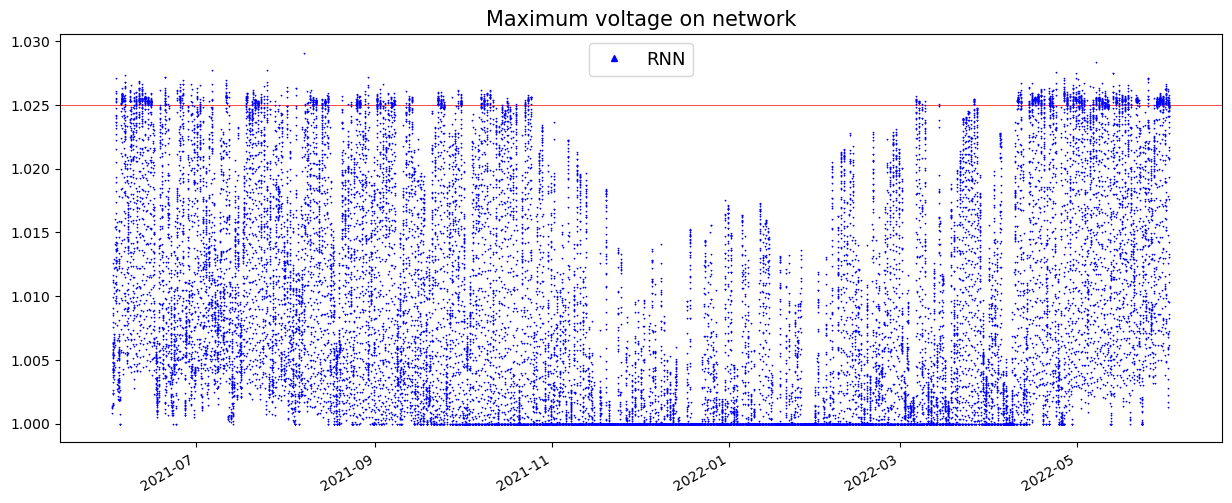

In [65]:
fig, axx = plt.subplots(figsize=(15,6), dpi=100)
plt.axhline(vm_mu_max,color='r', lw=0.5)

max_vm_pu_rnn_df.plot(style = ['b^'],markersize=0.5, ax=axx)
plt.legend( fontsize=13, markerscale=10)
plt.title("Maximum voltage on network", fontsize=15);

#### Setting up variables

In [67]:
ctrld_HvProd_df = df_final.loc[df_final2.index, [ctrld_HvProd_name]]
ctrld_HvProd_rnn_df = pd.DataFrame(data=extracted_results.loc[df_final2.index,ctrld_HvProd_name ].values,
                            index=extracted_results.loc[df_final2.index].index, 
                            columns=['RNN'] )
# Concat
ctrld_HvProd_concat_df = pd.concat([ctrld_HvProd_df,ctrld_HvProd_rnn_df], axis=1)

# Rename
ctrld_HvProd_concat_df.rename(columns=({ctrld_HvProd_name:'No_Control'}), inplace=True);

<AxesSubplot:>

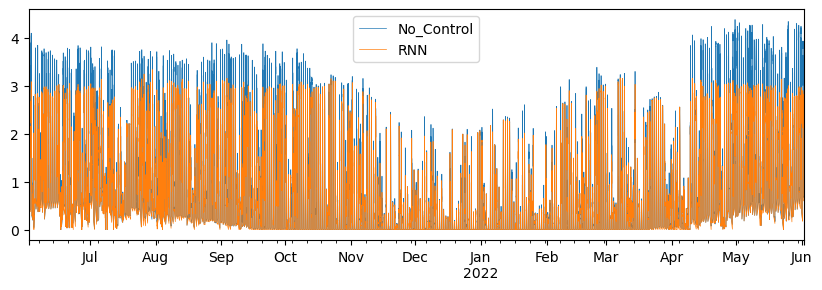

In [68]:
ctrld_HvProd_concat_df.plot(figsize=(10,3), lw=0.5)

In [69]:
# Compute Energy
var_no_control, var_rnn = ctrld_HvProd_concat_df.sum()*Δt

print(f'{ctrld_HvProd_name} prod,   No Control  : {var_no_control:.2f} MWh')
print(f'{ctrld_HvProd_name} prod, Future known  : {var_rnn:.2f} MWh |  Perc = {var_rnn*100/var_no_control:.2f}%')


P0100 prod,   No Control  : 5198.97 MWh
P0100 prod, Future known  : 4564.62 MWh |  Perc = 87.80%


##### Save Variables
*<span style='color:green'>Run the following cell only one </span>*

In [76]:
var_to_save = dict({f'{ctrld_HvProd_name}_concat_df':ctrld_HvProd_concat_df,
                    'voltage_rise_df':max_vm_pu_rnn_df, 
                    'Out_blocProd': extracted_results.loc[df_final2.index]# Where out bloc prod is the result 
                                                                          # of the prediction using the RNN model 
                                                                          # and the corresponding OPF voltage rise
                   })

joblib.dump(var_to_save,f'{simResult_folder}RNN_pred_res.pkl')

['../Pickle_files/simulationResults/RNN_pred_res.pkl']